In [1]:
import numpy as np
import pandas as pd
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Preprocessing Data

In [2]:
def read_excel(data):
    df = pd.read_excel('Data Prep.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def read_excel_revisi(data):
    df = pd.read_excel('Data Prep Revisi.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df



def mirroring(df): 
    df_c = df.copy()
    df = df.fillna(0)
    df = df + df.T
    df[df_c.isnull() & (df == 0)] = None
    return df

def set_same_zero(df):
    df_column = df.columns.values
    df_column = set(df_column)
    df_index = df.index.values
    df_index = set(df_index)
    same_port = df_index & df_column

    # making same port data into 0 
    for i in same_port:
        df[i][i]=0
    return df


In [3]:
alpha_up = read_excel('alpha_up')

GAMMA_TL = read_excel('GAMMA_TL')

w = read_excel('w')
w = mirroring(w)
w = set_same_zero(w)

TL_char = read_excel_revisi('TL_char')
PL_char = read_excel_revisi('PL_char')
PR_char = read_excel_revisi('PR_char')

beta_up = read_excel('beta_up')

gamma_uu = read_excel('gamma_uu')
gamma_uu = mirroring(gamma_uu)
gamma_uu = set_same_zero(gamma_uu)


SIGMA_PL = read_excel('SIGMA_PL')



sigma_pr = read_excel('sigma_pr')

PSI_PR = read_excel('PSI_PR')

z_pr = read_excel('z_pr')

special_PR = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='special_PR')
special_PR = special_PR.applymap(lambda x: x.strip() if isinstance(x, str) else x)

port_item = pd.read_excel('data.xlsx',index_col=0 , sheet_name='Barang')
port_item = port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)

biaya_jarak_teus = read_excel_revisi('Biaya_Jarak_Teus')

wave_status = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='wave_status')
wave_status = wave_status.applymap(lambda x: x.strip() if isinstance(x, str) else x)

ports = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='ports')
ports = ports.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [4]:
R_list = ports[ports['port_type'] == 'R']['port'].to_list()
P_list = ports[ports['port_type'] == 'P']['port'].to_list()
PL_P_list = ['Banda Neira','Dobo','Ambon','Tual','Saumlaki']
PL_non_P_list = list(set(P_list)-set(PL_P_list))

In [5]:
special_P_port = special_PR.columns.to_list()
wave_status['PR_availability'] = wave_status['wave_h']<2

In [6]:
Ambon_R_list = special_PR['Ambon'].dropna().to_list()
Tual_R_list = special_PR['Tual'].dropna().to_list()
Saumlaki_R_list = special_PR['Saumlaki'].dropna().to_list()

In [7]:
TL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL1')
TL2_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL2')
PL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='PL1')
PR_Ambon_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Ambon')
PR_Saumlaki_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Saumlaki')
PR_Tual_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Tual')


#### Filling Data with Dummy Data

In [8]:
def fill_mean(df):
    df = df.fillna(df.mean().mean())
    return df

w = fill_mean(w)
SIGMA_PL = fill_mean(SIGMA_PL)
sigma_pr = fill_mean(sigma_pr)
z_pr = fill_mean(z_pr)
PSI_PR = fill_mean(PSI_PR)
PR_char = fill_mean(PR_char)
biaya_jarak_teus = fill_mean(biaya_jarak_teus)

# Data Dummy

In [9]:
all_port_item  = pd.read_csv('barang_dummy.csv',index_col=0)
all_port_item = all_port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [10]:
# from_list = all_port_item['Pelabuhan'].to_list()
# for i in range(len(all_port_item)):
#     all_port_item['Tujuan Pelabuhan'].iloc[0] = random.choice(from_list)

# Creating Objects and Function

In [11]:
def quickport(port_name):
    name = ports[ports['port'] == port_name]['port'].values[0]
    port_type = ports[ports['port'] == port_name]['port_type'].values[0]
    return Port(name,port_type)

In [12]:
def chooseport(port_name):
    port_name = port_name.rstrip()
    port_name = port_name.lstrip()
    return ports[ports['port'] == port_name]['port_object'].iloc[0]

In [13]:
def add_TL_route(route):
    finished = False
    i = 0
    while finished == False:
        current_item = route[i]
        if current_item.name in ['Ambon','Saumlaki','Tual']:
            k=0
            for j in movable_TL[current_item.name]:
                k+=1
                route.insert(i+k,j)
            i+=len(movable_TL[current_item.name])
        i+=1
        if len(route) <= i:
            break
    return route

In [14]:
def port_items(port):
    global all_port_item
    item_list = all_port_item[all_port_item['Pelabuhan'] == port]
    return item_list

In [15]:
def find_distance(port_a,port_b):
    distance = 10+(np.random.rand()*20) #TODO: FIND DISTANCE
    return distance

In [16]:
def choose_char(ship_type):
    global TL_char, PL_char, PR_char
    if ship_type=='TL':
        ship_char = TL_char
    elif ship_type=='PL':
        ship_char = PL_char
    elif ship_type=='PR':
        ship_char = PR_char
    return ship_char

In [17]:
def per_item_revenue(data):
    distance = find_distance(data['Pelabuhan'],data['Tujuan Pelabuhan'])
    Bobot = data['Bobot']
    BJT = biaya_jarak_teus[data['Pelabuhan']][data['Tujuan Pelabuhan']]
    income = distance*Bobot*BJT
    return income

In [18]:
def port_revenue(storage_df):
    total_income = 0
    for i in storage_df.index:
        income = per_item_revenue(storage_df.loc[i])
        total_income += income
    return total_income

In [19]:
def item_left(df):
    return int(df['Bobot'].sum())

In [20]:
def find_movable_port(ship_type,port_name):
    if ship_type == 'TL':
        flag = False
    elif ship_type == 'PR':
        flag = True
    else:
        added_route = []
        return added_route
    r_list = special_PR[port_name].dropna().to_list()
    route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
    added_route = []
    for i in route_list:
        added_route.append(chooseport(i))
    return added_route

In [21]:
def all_item(available_ship):
    itemdf = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan'])
    itemdf.index.name = 'code barang'
    for i in ports['port_object']:
        itemdf = itemdf.append(i.demand)
    for i in available_ship:
        itemdf = itemdf.append(i.storage)
    return itemdf

In [22]:
def create_route(route_list):
    route = []
    for i in route_list:
        route.append(chooseport(i))
    return route
    

In [23]:
def total_revenue(available_ship):
    total_revenue = 0
    for i in available_ship:
        total_revenue += i.revenue
    return total_revenue

In [24]:
def get_route(df):
    return df['Route'].to_list()

In [25]:
class Port:
    def __init__(self, name,port_type):
        self.name = name
        self.port_type = port_type
        self.demand = port_items(name)
        
    
    def __repr__(self):
        if self.port_type == 'U':
            port_type_name = 'Utama'
        elif self.port_type == 'P':
            port_type_name = 'Pengumpul'
        elif self.port_type == 'R':
            port_type_name = 'Pengumpan'
        else:
            port_type_name = 'NOT DEFINED'

        return port_type_name + ":" + self.name
    

In [26]:
class Ship:
    def __init__(self, ship_type, route=[], name='No Name'):
        self.name = name
        self.ship_type = ship_type
        self.revenue = 0
        self.route = route
        self.current_port = route[0]
        self.port_cycle = route
        self.route_list = []
        self.ship_char = choose_char(self.ship_type)
        self.destination_dist = 0
        self.current_dist = 1000
        self.speed = self.ship_char['ship_char']['V']
        for i in route:
            self.route_list.append(i.name)

        storage_df = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan'])
        storage_df.index.name = 'code barang'
        self.storage = storage_df
        self.storage_volume = storage_df['Bobot'].sum()
        
        #Capacity
        self.capacity = self.ship_char['ship_char']['VC']
        
        
        #special route for TL depending on wave height
        if self.ship_type == 'TL':
            self.TL_Special_PR = list(set(route).intersection(set(special_PR.columns))) #TODO : CHECK PR NOT IN AND IN BASED ON WAVE
            portcycle_name =[]
            for i in self.port_cycle:
                portcycle_name.append(i.name)
            P_port_PR_transitport =  list(set(portcycle_name).intersection(set(special_PR.columns)))
            P_port_non_PR_transitport = [x for x in special_PR.columns if x not in P_port_PR_transitport]
            
            self.PR_transitport = []
            self.non_PR_transitport = []

            for i in P_port_PR_transitport:
                self.PR_transitport.extend(special_PR[i].dropna().to_list())
            for i in P_port_non_PR_transitport:
                self.non_PR_transitport.extend(special_PR[i].dropna().to_list())

    def update_storage_volume(self):
        self.storage_volume = self.storage['Bobot'].sum()

    def cycle_list(self):
        self.port_cycle = list(self.port_cycle[1:])+[self.port_cycle[0]]

    def find_destination(self):
        pick_item = False

        i = 0
        while pick_item == False:
            if i < len(self.port_cycle):
                pick_item = self.simulate_moving()
                if pick_item == False:
                    self.cycle_list()
            else:
                return
            i += 1
        self.cycle_list()
        self.destination = self.port_cycle[0]
        return self.destination
    
    def move_port(self):
        self.current_port = self.port_cycle[0]

    def cost_per_item(self,item ):
        print('item: '+str(item))
        Bobot = item['Bobot']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        C_bm = self.ship_char[self.current_port.name ]['C_bm']
        inventory_cost = self.ship_char[self.current_port.name ]['inventory_cost']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        avg_docking_time = self.ship_char[self.current_port.name ]['avg_docking_time']
#         distance = find_distance(item['Pelabuhan'],self.current_port.name )
        distance = item['Jarak']
        V = self.ship_char['ship_char']['V']
        VC = self.ship_char['ship_char']['VC']
        port_storage_time = self.ship_char[self.current_port.name ]['port_storage_time']
        C_storage = self.ship_char[self.current_port.name ]['C_storage']

        total_cost_bongkar = Bobot*bm_time*C_bm
        total_cost_storage = Bobot * port_storage_time * C_storage
        total_cost_travel_time = inventory_cost*bm_time*(avg_docking_time*(distance/V))
        cost_bongkar_time = inventory_cost * (Bobot/C_bm)
        print('bongkar: {} storage: {} travelT: {} btime: {}'.format(total_cost_bongkar,total_cost_storage,total_cost_travel_time,cost_bongkar_time))

        travel_cost = total_cost_bongkar + total_cost_storage+total_cost_travel_time+cost_bongkar_time
        
        return travel_cost, [total_cost_bongkar, total_cost_storage, total_cost_travel_time, cost_bongkar_time]
    
    def drop_off_item(self,tujuan_pelabuhan,finish_shipping = True):
        ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.storage = pd.concat([self.storage, ship_item]).drop_duplicates(keep=False)
        
        if finish_shipping == False:
            ship_item['Pelabuhan'] = self.current_port.name
            self.current_port.demand = self.current_port.demand.append(ship_item)
        elif finish_shipping == True:
            self.revenue += port_revenue(ship_item)
        
        #CALCULATING SHIP COST        
        total_cost_bongkar = 0
        total_cost_storage = 0
        total_cost_travel_time = 0
        cost_bongkar_time = 0
        travel_cost = 0
        for i in list(ship_item.index):
            item = ship_item.loc[i]
            travel_cost,_ = self.cost_per_item(item)
        self.revenue -= travel_cost

        self.update_storage_volume()
            
        return ship_item
    
    def pick_up_each(self,port_item):
        for i in port_item.index:
            current_port_item = port_item.loc[i]
            bobot_item = current_port_item['Bobot']
            if (self.storage_volume + bobot_item)<=self.capacity:
                bobot_item_df = pd.DataFrame(current_port_item).T
                self.current_port.demand = pd.concat([self.current_port.demand, bobot_item_df]).drop_duplicates(keep=False)
                bobot_item_df['Jarak'] = 0
                self.storage = self.storage.append(bobot_item_df)
                self.update_storage_volume()    
    
    def pick_up_port(self,tujuan_pelabuhan):
        port_item = self.current_port.demand[self.current_port.demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.pick_up_each(port_item)

    def check_item(self,tujuan_pelabuhan,pick_or_drop,pick_item=False):
        if pick_item == True:
            return pick_item
        else:
            if pick_or_drop == 'drop':
                ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(ship_item.empty)
            elif pick_or_drop == 'pick':
                port_item = self.port_cycle[1].demand[self.port_cycle[1].demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(port_item.empty)
            return pick_item
    
    def simulate_moving(self):
        # ITEM DROP OFF--------------------------------------------------------
        simulated_port = self.port_cycle[1]
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        pick_item = False
        pick_item = self.check_item(simulated_port.name,'drop',pick_item=pick_item)

        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if simulated_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
        

        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:            
            #FOR TL
            if self.ship_type == 'TL':
                pick_item = self.check_item('Tanjung Priok','drop',pick_item=pick_item)
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in P_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in U_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)

       #for Special PR (Ambon, Tual, and Saumlaki)
        if simulated_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[simulated_port.name].dropna().to_list()                
                for i in current_port_R_ports:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',simulated_port.name)
                for i in current_r:
                    pick_item = self.check_item(i.name,'drop',pick_item=pick_item)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            pick_item = self.check_item(i.name,'pick',pick_item=pick_item)

        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if simulated_port.name not in special_PR.columns:
                for i in R_list:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                if pick_item == True:
                    pass
                else:
                    pick_item = not(port_item.empty)
                    
#         P not in special P
        if ((simulated_port.port_type == 'P') and (simulated_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)


        #for Tanjung Priok
        if simulated_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = simulated_port.demand
                pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            
        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        pick_item = self.check_item(j,'pick',pick_item=pick_item)     
            elif self.ship_type == 'PL':
                pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for Special PR
        if simulated_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',simulated_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(simulated_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',simulated_port.name)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for R
        if simulated_port.name in R_list:
            port_item = simulated_port.demand
            pick_item = self.check_item(i,'pick',pick_item=pick_item) #TODO 

            if pick_item == True:
                pass
            else:
                pick_item = not(port_item.empty)

            
        # ITEM PICK UP--------------------------------------------------------
        return pick_item
    
    def move_storage(self):
        # ITEM DROP OFF--------------------------------------------------------
        
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        self.drop_off_item(self.current_port.name)
        
        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if self.current_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    self.drop_off_item(i,finish_shipping = False)
        
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            
            #FOR TL
            if self.ship_type == 'TL':
                self.drop_off_item('Tanjung Priok',finish_shipping = False )
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    self.drop_off_item(i,finish_shipping = False )
                for i in P_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)
                for i in U_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)

            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    self.drop_off_item(i,finish_shipping = False )

       #for Special PR (Ambon, Tual, and Saumlaki)
        if self.current_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[self.current_port.name].dropna().to_list() 
                for i in current_port_R_ports:
                    self.drop_off_item(i.strip(),finish_shipping = False)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',self.current_port.name)
                for i in current_r:
                    self.drop_off_item(i.name,finish_shipping = False)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            self.pick_up_port(i.name)
        
        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.pick_up_port('Tanjung Priok')
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.pick_up_port('Tanjung Priok')
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if self.current_port.name not in special_PR.columns:
                for i in R_list:
                    self.pick_up_port(i)
                    
            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)   
                
#         P not in special P
        if ((self.current_port.port_type == 'P') and (self.current_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    self.pick_up_port(i)


        #for Tanjung Priok
        if self.current_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)
                
            
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        self.pick_up_port(j)     
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')

        #for Special PR
        if self.current_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',self.current_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(self.current_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    self.pick_up_port(i)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',self.current_port.name)
                for i in port_PR_ports:
                    self.pick_up_port(i)

        #for R
        if self.current_port.name in R_list:
            port_item = self.current_port.demand
            self.pick_up_each(port_item)

            
        # ITEM PICK UP--------------------------------------------------------
      
    def __repr__(self):
        return self.ship_type +': '+ self.ship_type

In [27]:
ports['port_object'] = ports['port'].apply(lambda x: quickport(x))

In [28]:
movable_TL = {'Ambon' : find_movable_port('TL','Ambon'),
              'Tual' : find_movable_port('TL','Tual'),
              'Saumlaki' : find_movable_port('TL','Saumlaki')}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [29]:
route_list = ['Tanjung Perak','Saumlaki','Tanjung Priok','Dobo','Namlea']
route = create_route(route_list)

In [30]:
route_list_TL1 = get_route(TL1_data)
route_TL1 = create_route(route_list_TL1)
route_TL1 = add_TL_route(route_TL1)

route_list_TL2 = get_route(TL2_data)
route_TL2 = create_route(route_list_TL2)
route_TL2 = add_TL_route(route_TL2)

route_list_PL1 = get_route(PL1_data)
route_PL1 = create_route(route_list_PL1)

route_list_PR_Ambon = get_route(PR_Ambon_data)
# route_PR_Ambon = create_route(route_list_PR_Ambon)
route_PR_Ambon = [chooseport('Ambon')]+find_movable_port('PR','Ambon')

route_list_PR_Tual = get_route(PR_Tual_data)
# route_PR_Tual = create_route(route_list_PR_Tual)
route_PR_Tual = [chooseport('Tual')]+find_movable_port('PR','Tual')

route_list_PR_Saumlaki = get_route(PR_Saumlaki_data)
# route_PR_Saumlaki = create_route(route_list_PR_Saumlaki)
route_PR_Saumlaki = [chooseport('Saumlaki')]+find_movable_port('PR','Saumlaki')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [31]:
TL_tester = Ship('TL',route)
TL1 = Ship('TL',route_TL1)
TL2 = Ship('TL',route_TL2)
PL1 = Ship('PL',route_PL1)
PR_Ambon = Ship('PR',route_PR_Ambon)
PR_Tual = Ship('PR',route_PR_Tual)
PR_Saumlaki = Ship('PR',route_PR_Saumlaki)



In [32]:
available_ship = [TL_tester,TL1,TL2,PL1,PR_Ambon,PR_Tual,PR_Saumlaki]

In [33]:
def port_sequence(ship):
    if ship.destination_dist<=ship.current_dist:
        ship.move_port()
        print('')
        print('')
        print('')
        print('')
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print('ship_type: '+ship.ship_type)
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print('BEFORE')
        print('current port:' + ship.current_port.name)
        print('')
        print('PORT DEMAND:')
        print(ship.current_port.demand)
        print('')
        print('SHIP STORAGE:')
        print(ship.storage)
        ship.move_storage()
        print('oOoOoOoOoOoOoOoOoOoOoOoO')
        print('AFTER')
        print('current port:' + ship.current_port.name)
        print('')
        print('PORT DEMAND:')
        print(ship.current_port.demand)
        print('')
        print('SHIP STORAGE:')
        print(ship.storage)
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        ship.find_destination()
        ship.destination_dist = find_distance(ship.destination.name, ship.current_port.name)
        ship.current_dist = 0
    elif ship.destination_dist>ship.current_dist:
        ship.storage['Jarak'] = ship.storage['Jarak']+ship.speed
        ship.current_dist+=ship.speed

        


In [34]:
import time
import math
new_port_item = all_item(available_ship)
remaining = item_left(new_port_item)
i=0
remaining_history = []
tic = time.clock()
while remaining>0:
    i +=1
#     port_sequence(TL1)
    print('TL1 revenue: {}'.format(TL1.revenue))
    port_sequence(TL2)
    print('TL2 revenue: {}'.format(TL2.revenue))
    port_sequence(PL1)
    print('PL1 revenue: {}'.format(PL1.revenue))
    port_sequence(PR_Ambon)
    print('PR_Ambon revenue: {}'.format(PR_Ambon.revenue))
    port_sequence(PR_Tual)
    print('PR_Tual revenue: {}'.format(PR_Tual.revenue))
    port_sequence(PR_Saumlaki)
    print('PR_Saumlaki revenue: {}'.format(PR_Saumlaki.revenue))
    new_port_item = all_item(available_ship)
    remaining = item_left(new_port_item)
    print('************************************************')
    print('revenue: {}'.format(total_revenue(available_ship)))
    print('remaining: ' + str(remaining))
    print('iteration: ' + str(i))
    print('************************************************')
    if math.isnan(total_revenue(available_ship)) == True:
        break
    remaining_history.append(remaining)

    if i>=1000:
        break
toc = time.clock()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


TL1 revenue: 0




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Makassar

PORT DEMAND:
     Pelabuhan  Bobot   Tujuan Pelabuhan
A3    Makassar      9           Saumlaki
A94   Makassar      4  Arwala/Sutilirang
A185  Makassar      1            Ambalau
A276  Makassar      9      Tanjung Priok

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
     Pelabuhan Bobot   Tujuan Pelabuhan
A94   Makassar     4  Arwala/Sutilirang
A185  Makassar     1            Ambalau
A276  Makassar     9      Tanjung Priok

SHIP STORAGE:
   Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A3     9    0.0  Makassar         Saumlaki
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: 0




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Priok

PORT DEMAND:
          Pelabuhan  Bobot Tujuan Pelabuhan
A1    Tanjung 

PR_Saumlaki revenue: 0
************************************************
revenue: 42906698.56503771
remaining: 1779
iteration: 5
************************************************
TL1 revenue: 0




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Luang

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A81    P.Luang      1           Weduar
A172   P.Luang      8         Kelimuri
A263   P.Luang      3             Elat
A354   P.Luang      8          P.Geser

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A280     9   12.0  Saumlaki         Kelimuri
A98      2   12.0  Saumlaki          P.Geser
A189     2   12.0  Saumlaki            Fadol
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A280     9   12.0  Saumlaki         Kelimuri
A98      2   12.0  Saumlaki          P.Geser
A189

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Neira

PORT DEMAND:
        Pelabuhan Bobot Tujuan Pelabuhan
A194  Banda Neira     6           Amahai
A285  Banda Neira     5           P.Leti

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A2       1   20.0     Makassar           Saumlaki
A276     9   20.0     Makassar      Tanjung Priok
A185     1   20.0     Makassar            Ambalau
A275     2   20.0     Makassar          Waemulang
A1       9   20.0     Makassar          Waemulang
A274     4   20.0     Makassar              Wahai
A183     1   20.0     Makassar           Werinama
A92      2   20.0     Makassar             Mangur
A184     4   20.0     Makassar  Sofyanin/Rumayaan
A93      6   20.0     Makassar               Nila
A94      4   20.0     Makassar  Arwala/Sutilirang
A12      3    0.0  Banda Neira           Kelimuri
A103     2    0.0  Banda Neira              Fadol
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -5641032.25
PR_Ambon revenue: 0
PR_Tual revenu

item: Bobot                    4
Jarak                   60
Pelabuhan           Manipa
Tujuan Pelabuhan    Amahai
Name: A110, dtype: object
bongkar: 14000.0 storage: 275.0 travelT: 540000.0 btime: 5.142857142857143
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Amahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A101     3   84.0      Ambon            Buano
A19      7   60.0     Manipa           Kaimer
A201     5   60.0     Manipa          Benjina
A292     9   60.0     Manipa        Banda Eli
A108     1   36.0  Waemulang             Tifu
A17      9   36.0  Waemulang             Fogi
A199     7   36.0  Waemulang           Weduar
A290     3   36.0  Waemulang            Jerol
A303     6    0.0     Amahai    Tanjung Priok
A30      9    0.0     Amahai            Wulur
A121     1    0.0     Amahai           Kisar1
A212     2    0.0     Amahai          Benjina
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR

************************************************
revenue: 199667575.3877874
remaining: 1768
iteration: 13
************************************************
TL1 revenue: 0
TL2 revenue: 45898710.56503771
PL1 revenue: -9100045.75
PR_Ambon revenue: 70492403.57783416
PR_Tual revenue: 92376506.99491552
PR_Saumlaki revenue: 0
************************************************
revenue: 199667575.3877874
remaining: 1768
iteration: 14
************************************************
TL1 revenue: 0
TL2 revenue: 45898710.56503771
PL1 revenue: -9100045.75




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Leksula

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A15    Leksula      4           Mangur
A106   Leksula      5            Wahai
A197   Leksula      8       P.Manawoka
A288   Leksula      3           Kaimer

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A101     3  120.0      Ambon            Buano
A19      7   96.0     Mani

************************************************
revenue: 251880964.33863628
remaining: 1763
iteration: 17
************************************************
TL1 revenue: 0
TL2 revenue: 45898710.56503771




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A2       1  140.0  Makassar           Saumlaki
A276     9  140.0  Makassar      Tanjung Priok
A184     4  140.0  Makassar  Sofyanin/Rumayaan
A93      6  140.0  Makassar               Nila
A94      4  140.0  Makassar  Arwala/Sutilirang
item: Bobot                      1
Jarak                    140
Pelabuhan           Makassar
Tujuan Pelabuhan    Saumlaki
Name: A2, dtype: object
bongkar: 40000.0 storage: 8500.0 travelT: 630000.0 btime: 0.75
item: Bobot                               4
Jarak                             140
Pela

************************************************
revenue: 259030436.29505816
remaining: 1762
iteration: 20
************************************************
TL1 revenue: 0
TL2 revenue: 45898710.56503771




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A276     9  180.0  Makassar    Tanjung Priok
item: Bobot                           9
Jarak                         180
Pelabuhan                Makassar
Tujuan Pelabuhan    Tanjung Priok
Name: A276, dtype: object
bongkar: nan storage: nan travelT: nan btime: nan
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


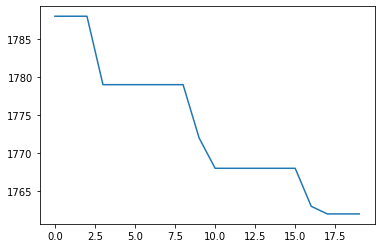

In [35]:
plt.plot(remaining_history)

In [36]:
print(toc-tic)

7.351107313


In [37]:
TL1.destination

AttributeError: 'Ship' object has no attribute 'destination'

In [ ]:
current_r = find_movable_port('PR','Saumlaki')
print('current r:      ^^^^^^^^^^^^^^^^^^^^^')
print(current_r)
for i in current_r:
    if i.name == 'Arwala/Sutilirang':
        print(i)
    TL1.drop_off_item(i.name,finish_shipping = False)

In [ ]:
PR_Saumlaki.storage

In [ ]:
chooseport('Tanjung Perak').demand

In [ ]:
~PR_Tual.storage['Pelabuhan'].isin(['Tual'])

In [ ]:
total_revenue(available_ship)

In [ ]:
a = all_port_item.loc['A1']
a['Jarak'] = 10


In [ ]:
b = pd.DataFrame(a).T
all_port_item.append(b)

In [ ]:
TL1.revenue